In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pylaxz

In [8]:
img_path = './predicted.jpg'
img = cv2.imread(img_path)

In [15]:
def show(img):
    plt.imshow(img, cmap='gray')

In [16]:
def gray(img, swap= False):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY if not swap else cv2.COLOR_RGB2GRAY)

def blur(gray, kernel=(23,23)):
    return cv2.GaussianBlur(gray, kernel, 0)

def binary(gray):
    return cv2.threshold(src=gray, thresh=180, maxval=255, type=cv2.THRESH_OTSU)[1]

def thre_mor(blur):
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    thre_mor = cv2.morphologyEx(blur, cv2.MORPH_DILATE, kernel3)
    return thre_mor

def proj(preprocessed_img):
    projs = np.sum(preprocessed_img, 1)
    m = np.max(projs)
    h, w = preprocessed_img.shape[:2]
    result = np.zeros((h,w))
    # Draw a line for each row
    for row in range(h):
        cv2.line(result, (0,row), (int(projs[row]*w/m),row), (255,255,255), 1)

    return (result, projs)

Text(0.5, 1.0, 'dilation')

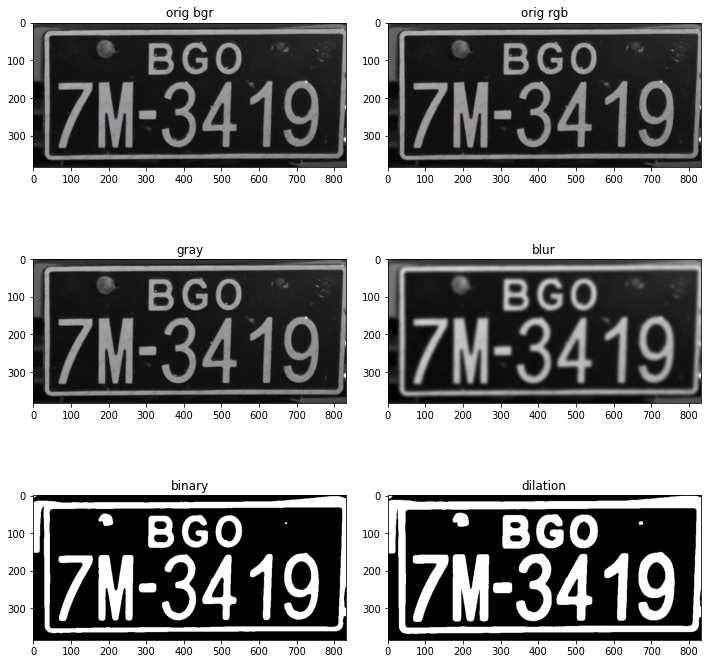

In [14]:
fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(10, 10))
fig.tight_layout()

axes[0][0].imshow(img)
axes[0][0].set_title('orig bgr')
   
axes[0][1].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
axes[0][1].set_title('orig rgb')

gray_img = gray(img)
axes[1][0].imshow(gray_img, cmap='gray')
axes[1][0].set_title('gray')

blur_img = blur(gray_img, kernel=(21,21))
axes[1][1].imshow(blur_img, cmap='gray')
axes[1][1].set_title('blur')

bin_img= binary(blur_img)
axes[2][0].imshow(bin_img, cmap='gray')
axes[2][0].set_title('binary')

dia_img = thre_mor(bin_img)
axes[2][1].imshow(dia_img, cmap='gray')
axes[2][1].set_title('dilation')

In [23]:
def proj_points(projs=None, ratio=5, verbose=False, bias=10):
    length_proj = len(projs)
    if True:
        # magic happened
        fs = int(bias) # first select point with bias
        fe = int (length_proj/ratio) + bias # (1 / ratio ) + bias 
        s =  int(fe + bias / 2) # (1 / ratio ) + bias + bias / 2
        e =  int(( 2 * s ) - bias) # (2 / ratio ) - bias
        if verbose : print(fs, fe, s, e)

        first_min_pt = min(projs[fs:fe])
        second_min_pt = min(projs[s:e])
        
        if verbose : print(first_min_pt, second_min_pt)
            
        first_ref_pt = np.where(projs == first_min_pt)
        second_ref_pt = np.where(projs == second_min_pt)
        
        if verbose : print(first_ref_pt, second_ref_pt)
        if len(second_ref_pt) < 3 :
            # narrow bandwidh
            second_ref_pt = list(range(second_ref_pt[0][0] - 5 , second_ref_pt[0][0] + 5 ))
    
        if len(first_ref_pt) < 3:
            # narrow bandwidh
            first_ref_pt = list(range(first_ref_pt[0][0] - 5 ,first_ref_pt[0][0] + 5 ))
    
    return (first_ref_pt,second_ref_pt)

30 106 121 212
14535 13770
(array([43, 44, 45, 46]),) (array([142]),)


Text(0.5, 1.0, 'lower region')

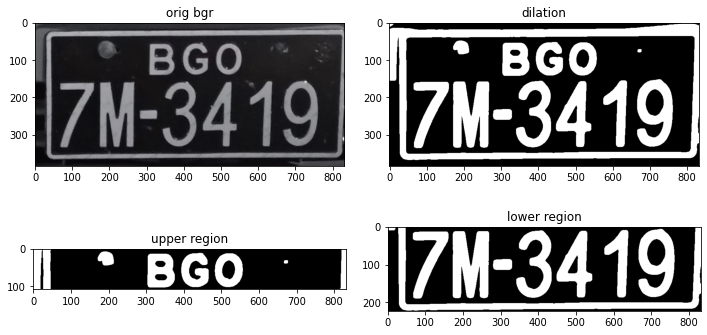

In [35]:
res, projs = proj(dia_img)

first_ref_pt,second_ref_pt = proj_points(projs, ratio=5, verbose=True , bias=30)
upper = dia_img[first_ref_pt[0]:second_ref_pt[-1]]
lower = dia_img[second_ref_pt[-1]: len(projs)-15]

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10, 5))
fig.tight_layout()

axes[0][0].imshow(img, cmap='gray')
axes[0][0].set_title('orig bgr')
axes[0][1].imshow(dia_img, cmap='gray')
axes[0][1].set_title('dilation')
axes[1][0].imshow(upper, cmap='gray')
axes[1][0].set_title('upper region')
axes[1][1].imshow(lower, cmap='gray')
axes[1][1].set_title('lower region')

In [36]:
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

Detect 6 letters...


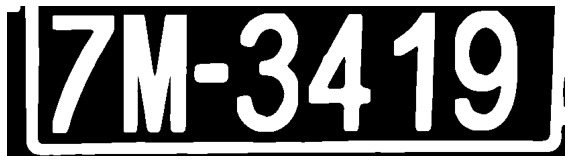

In [39]:
cont, _  = cv2.findContours(lower, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
digit_w, digit_h = 30, 60
copy_upper = lower.copy()
crop_characters = []

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/upper.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(copy_upper, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = dia_img[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)
        
print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(copy_upper, cmap='gray')

# GOOOOOOOOOOOOOOOOOOOOOOD